In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8")


In [171]:
import pandas as pd

df_import_raw = pd.read_csv("import.csv", encoding="latin1")
df_import_raw.head()

,Mineral,2019,Unnamed: 2,2020,Unnamed: 4,2021,Unnamed: 6,2022,Unnamed: 8,2023,Unnamed: 10,2024,Unnamed: 12,2025,Unnamed: 14
0,NaN,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value
1,Asbestos,"3,64,105","1,225.31","3,61,164","1,243.23","3,08,506","1,185.11","4,37,509","1,663.14","4,04,152","2,294.04","465,449","2,326.04","376,521","2,119"
2,Bauxite,"20,75,104","1,222.13","22,46,464","1,080.88","30,33,706","1,370.11","30,08,588","1,894.61","35,95,844","2,340.30","4,502,798","2,822.16","3,140,478","2,568"
3,Chromite,"1,62,663",315.44,"1,24,693",206.5,"1,56,211",225.77,"2,45,711",423.25,"1,11,291",296.99,172410.21,456.39,"257,372",761
4,Copper Ores & Conc.,"8,23,938","12,146.20","8,21,555","8,667.52","4,15,136","5,907.16","10,18,935","22,381.43","11,78,920","27,374.43",1016300.97,"25,951.23","1,175,592","32,558"


In [172]:
df_import = df_import_raw.drop(index=0).reset_index(drop=True)
df_import.head()

,Mineral,2019,Unnamed: 2,2020,Unnamed: 4,2021,Unnamed: 6,2022,Unnamed: 8,2023,Unnamed: 10,2024,Unnamed: 12,2025,Unnamed: 14
0,Asbestos,"3,64,105","1,225.31","3,61,164","1,243.23","3,08,506","1,185.11","4,37,509","1,663.14","4,04,152","2,294.04","465,449","2,326.04","376,521","2,119"
1,Bauxite,"20,75,104","1,222.13","22,46,464","1,080.88","30,33,706","1,370.11","30,08,588","1,894.61","35,95,844","2,340.30","4,502,798","2,822.16","3,140,478","2,568"
2,Chromite,"1,62,663",315.44,"1,24,693",206.5,"1,56,211",225.77,"2,45,711",423.25,"1,11,291",296.99,172410.21,456.39,"257,372",761
3,Copper Ores & Conc.,"8,23,938","12,146.20","8,21,555","8,667.52","4,15,136","5,907.16","10,18,935","22,381.43","11,78,920","27,374.43",1016300.97,"25,951.23","1,175,592","32,558"
4,Silicious Earth,"3,972",15.67,"5,230",16.35,"7,375",22.65,"2,187",11.62,"4,192",27.96,"2,634",18.4,"4,735",34


In [173]:
year_value_map = {
    "2019": "Unnamed: 2",
    "2020": "Unnamed: 4",
    "2021": "Unnamed: 6",
    "2022": "Unnamed: 8",
    "2023": "Unnamed: 10",
    "2024": "Unnamed: 12",
    "2025": "Unnamed: 14"
}


In [174]:
import numpy as np

yearly_imports = []

for year, val_col in year_value_map.items():
    
    # Step 1: Clean strings
    values = (
        df_import[val_col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .replace("-", np.nan)
    )
    
    # Step 2: Convert to numeric
    values = pd.to_numeric(values, errors="coerce")
    
    # Step 3: Fill missing with column mean (IMPORTANT)
    values = values.fillna(values.mean())
    
    # Step 4: Aggregate yearly import
    yearly_imports.append({
        "Year": int(year),
        "Import": values.sum()
    })

df_import_final = pd.DataFrame(yearly_imports)
df_import_final


,Year,Import
0,2019,9.827902e+05
1,2020,8.154311e+05
2,2021,8.574255e+05
3,2022,1.333946e+06
4,2023,1.275395e+06
5,2024,1.412695e+06
6,2025,1.758010e+06


In [175]:
df_import_final["Year"] = pd.to_datetime(df_import_final["Year"], format="%Y")
df_import_final.set_index("Year", inplace=True)
df_import_final


,Import
Year,
2019-01-01,9.827902e+05
2020-01-01,8.154311e+05
2021-01-01,8.574255e+05
2022-01-01,1.333946e+06
2023-01-01,1.275395e+06
2024-01-01,1.412695e+06
2025-01-01,1.758010e+06


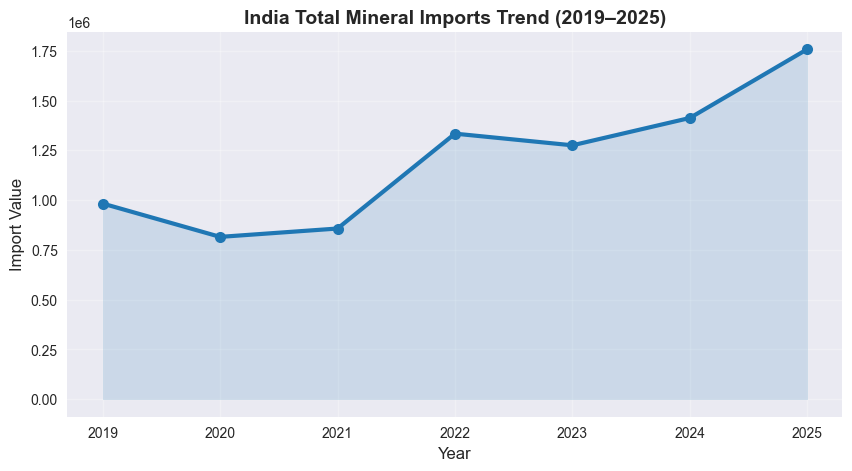

In [176]:
plt.figure(figsize=(10,5))

plt.plot(
    df_import_final.index.year,
    df_import_final["Import"],
    color="#1f77b4",
    linewidth=3,
    marker="o",
    markersize=8
)

plt.fill_between(
    df_import_final.index.year,
    df_import_final["Import"],
    color="#1f77b4",
    alpha=0.15
)

plt.title("India Total Mineral Imports Trend (2019–2025)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Import Value", fontsize=12)

plt.xticks(df_import_final.index.year)
plt.grid(alpha=0.3)

plt.show()


In [177]:
model_import = ARIMA(df_import_final["Import"], order=(0,1,0))
fit_import = model_import.fit()

print(fit_import.summary())


                               SARIMAX Results                                
Dep. Variable:                 Import   No. Observations:                    7
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -83.308
Date:                Mon, 29 Dec 2025   AIC                            168.616
Time:                        13:25:04   BIC                            168.407
Sample:                    01-01-2019   HQIC                           167.782
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.691e+10    3.2e+10      1.780      0.075   -5.77e+09     1.2e+11
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.47   Pr

C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [178]:
import_forecast = fit_import.forecast(steps=3)
import_forecast


2026-01-01    1.758010e+06
2027-01-01    1.758010e+06
2028-01-01    1.758010e+06
Freq: YS-JAN, Name: predicted_mean, dtype: float64

In [179]:
# In-sample ARIMA prediction
arima_pred_import = fit_import.predict(
    start=0,
    end=len(df_import_final) - 1
)

# Residuals = Actual - ARIMA
import_residuals = (
    df_import_final["Import"].values
    - arima_pred_import.values
)


In [180]:
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(
    import_residuals.reshape(-1, 1)
)

def create_sequences(data, window=3):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(residuals_scaled, window=3)

X_lstm = X_lstm.reshape(
    (X_lstm.shape[0], X_lstm.shape[1], 1)
)


In [181]:
lstm_model = Sequential([
    LSTM(32, activation="relu", input_shape=(X_lstm.shape[1], 1)),
    Dense(10)
])

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_lstm, y_lstm,batch_size=32, epochs=100, verbose=0)


C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [182]:
last_seq = residuals_scaled[-3:].reshape((1, 3, 1))

lstm_residual_forecast = []

for _ in range(3):
    pred = lstm_model.predict(last_seq, verbose=0)[0, 0]
    lstm_residual_forecast.append(pred)

    last_seq = np.roll(last_seq, -1, axis=1)
    last_seq[0, -1, 0] = pred


In [183]:
lstm_residual_forecast = scaler.inverse_transform(
    np.array(lstm_residual_forecast).reshape(-1, 1)
).flatten()


In [184]:
hybrid_import_forecast = (
    import_forecast.values
    + lstm_residual_forecast
)

hybrid_import_forecast


array([2022691.58534483, 2094735.24159483, 2141831.27284483])

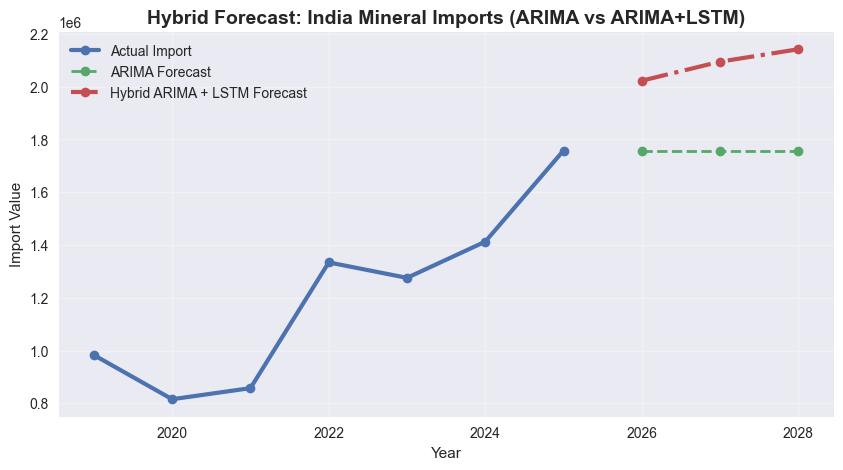

In [185]:
# Number of forecast steps
n_steps = len(import_forecast)

# Generate forecast years dynamically
last_year = df_import_final.index.year[-1]
forecast_years = range(last_year + 1, last_year + 1 + n_steps)

plt.figure(figsize=(10,5))

# ---------------- ACTUAL ----------------
plt.plot(
    df_import_final.index.year,
    df_import_final["Import"],
    label="Actual Import",
    marker="o",
    linewidth=3
)

# ---------------- ARIMA ----------------
plt.plot(
    forecast_years,
    import_forecast.values,
    label="ARIMA Forecast",
    linestyle="--",
    marker="o",
    linewidth=2
)

# ---------------- HYBRID ----------------
plt.plot(
    forecast_years,
    hybrid_import_forecast,
    label="Hybrid ARIMA + LSTM Forecast",
    linestyle="-.",
    marker="o",
    linewidth=3
)

# ---------------- STYLING ----------------
plt.title(
    "Hybrid Forecast: India Mineral Imports (ARIMA vs ARIMA+LSTM)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Year")
plt.ylabel("Import Value")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [186]:
df_import_final.reset_index().to_csv(
    "import_final.csv",
    index=False,
    encoding="utf-8"
)


In [187]:
df_export_raw = pd.read_csv("export.csv", encoding="latin1")
df_export_raw.head()


,Mineral,2019,Unnamed: 2,2020,Unnamed: 4,2021,Unnamed: 6,2022,Unnamed: 8,2023,Unnamed: 10,2024,Unnamed: 12,2025,Unnamed: 14
0,NaN,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value
1,Asbestos,"1,112",3.39,"1,001",3.1,298,1.2,"1,906",6.8,"3,286",21.75,"1,205",8.15,1,0.02
2,Bauxite,"15,02,915",302.76,"4,84,225",132.25,"63,886",56.24,"1,02,042",49.86,"95,407",40.04,"54,628",15.61,"359,315",113.58
3,Chromite,"39,273",133.77,"33,898",86.79,"2,872",7.2,"2,626",8.97,"33,881",90.42,"2,117",9.94,560,2.85
4,Copper Ores & Conc.,"1,81,642","1,662.76","2,12,659","2,045.09","82,463",768.94,"34,827",396.46,"26,336",243.54,"23,188",243.03,"16,426",196.83


In [188]:
df_export = df_export_raw.drop(index=0).reset_index(drop=True)
df_export.head()


,Mineral,2019,Unnamed: 2,2020,Unnamed: 4,2021,Unnamed: 6,2022,Unnamed: 8,2023,Unnamed: 10,2024,Unnamed: 12,2025,Unnamed: 14
0,Asbestos,"1,112",3.39,"1,001",3.1,298,1.2,"1,906",6.8,"3,286",21.75,"1,205",8.15,1,0.02
1,Bauxite,"15,02,915",302.76,"4,84,225",132.25,"63,886",56.24,"1,02,042",49.86,"95,407",40.04,"54,628",15.61,"359,315",113.58
2,Chromite,"39,273",133.77,"33,898",86.79,"2,872",7.2,"2,626",8.97,"33,881",90.42,"2,117",9.94,560,2.85
3,Copper Ores & Conc.,"1,81,642","1,662.76","2,12,659","2,045.09","82,463",768.94,"34,827",396.46,"26,336",243.54,"23,188",243.03,"16,426",196.83
4,Silicious Earth,"52,175",42.62,"4,518",7.76,"3,728",7.49,"2,047",6.07,"2,093",6.76,"2,768",7.41,"4,436",0.4


In [189]:
year_value_map = {
    "2019": "Unnamed: 2",
    "2020": "Unnamed: 4",
    "2021": "Unnamed: 6",
    "2022": "Unnamed: 8",
    "2023": "Unnamed: 10",
    "2024": "Unnamed: 12",
    "2025": "Unnamed: 14"
}


In [190]:
yearly_exports = []

for year, col in year_value_map.items():

    # Step 1: Clean strings
    values = (
        df_export[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .replace("-", np.nan)
    )

    # Step 2: Convert to numeric FIRST
    values = pd.to_numeric(values, errors="coerce")

    # Step 3: Fill NaN using numeric mean
    values = values.fillna(values.mean())

    yearly_exports.append({
        "Year": int(year),
        "Export": values.sum()
    })

df_export_final = pd.DataFrame(yearly_exports)


In [191]:
df_export_final["Year"] = pd.to_datetime(df_export_final["Year"], format="%Y")
df_export_final.set_index("Year", inplace=True)
df_export_final = df_export_final.sort_index()

df_export_final


,Export
Year,
2019-01-01,3.894708e+05
2020-01-01,3.469321e+05
2021-01-01,3.882469e+05
2022-01-01,4.598487e+05
2023-01-01,4.238706e+05
2024-01-01,1.334468e+06
2025-01-01,3.607195e+05


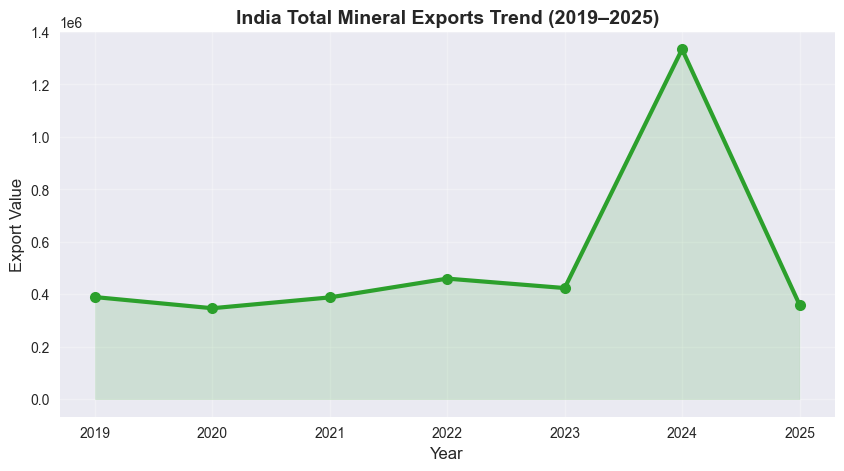

In [192]:
plt.figure(figsize=(10,5))

plt.plot(
    df_export_final.index.year,
    df_export_final["Export"],
    color="#2ca02c",
    linewidth=3,
    marker="o",
    markersize=8
)

plt.fill_between(
    df_export_final.index.year,
    df_export_final["Export"],
    color="#2ca02c",
    alpha=0.15
)

plt.title("India Total Mineral Exports Trend (2019–2025)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Export Value", fontsize=12)

plt.xticks(df_export_final.index.year)
plt.grid(alpha=0.3)

plt.show()


In [193]:
model_export = ARIMA(df_export_final["Export"], order=(1,0,1))
fit_export = model_export.fit()

print(fit_export.summary())


                               SARIMAX Results                                
Dep. Variable:                 Export   No. Observations:                    7
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -99.321
Date:                Mon, 29 Dec 2025   AIC                            206.643
Time:                        13:25:24   BIC                            206.426
Sample:                    01-01-2019   HQIC                           203.969
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.291e+05   1.77e+06      0.298      0.766   -2.95e+06    4.01e+06
ar.L1          0.5487     13.384      0.041      0.967     -25.683      26.780
ma.L1         -0.7985     15.206     -0.053      0.9

C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [194]:
export_forecast = fit_export.forecast(steps=3)
export_forecast


2026-01-01    468236.235411
2027-01-01    495697.002362
2028-01-01    510763.724658
Freq: YS-JAN, Name: predicted_mean, dtype: float64

In [195]:
# In-sample ARIMA prediction
arima_pred_export = fit_export.predict(
    start=0,
    end=len(df_export_final) - 1
)

# Residuals = Actual - ARIMA
export_residuals = (
    df_export_final["Export"].values
    - arima_pred_export.values
)


In [196]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_exp = MinMaxScaler()

export_res_scaled = scaler_exp.fit_transform(
    export_residuals.reshape(-1,1)
)

# Create sequences
def create_sequences(data, window=3):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X_exp, y_exp = create_sequences(export_res_scaled, window=3)


In [197]:
model_lstm_exp = Sequential([
    LSTM(32, activation="relu", input_shape=(X_exp.shape[1], 1)),
    Dense(10)
])

model_lstm_exp.compile(
    optimizer="adam",
    loss="mse"
)

model_lstm_exp.fit(
    X_exp, y_exp,
    epochs=200,
    batch_size=32,
    verbose=0
)


C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [198]:
# Forecast residuals for next 3 years
last_seq_exp = export_res_scaled[-3:].reshape(1,3,1)

lstm_res_forecast_exp = []

for _ in range(3):
    pred = model_lstm_exp.predict(last_seq_exp, verbose=0)[0][0]
    lstm_res_forecast_exp.append(pred)
    last_seq_exp = np.roll(last_seq_exp, -1)
    last_seq_exp[0, -1, 0] = pred

# Inverse scale
lstm_res_forecast_exp = scaler_exp.inverse_transform(
    np.array(lstm_res_forecast_exp).reshape(-1,1)
).flatten()


In [199]:
hybrid_export_forecast = export_forecast.values + lstm_res_forecast_exp
hybrid_export_forecast


array([516421.5244731 , 550718.34611233, 579152.60747002])

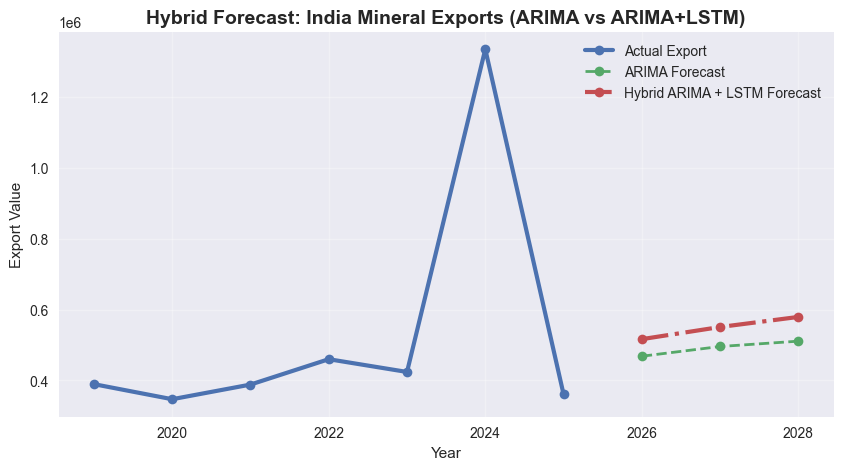

In [200]:
# Number of steps
n_steps = len(export_forecast)

last_year = df_export_final.index.year[-1]
forecast_years = range(last_year + 1, last_year + 1 + n_steps)

plt.figure(figsize=(10,5))

# Actual Export
plt.plot(
    df_export_final.index.year,
    df_export_final["Export"],
    label="Actual Export",
    marker="o",
    linewidth=3
)

# ARIMA Forecast
plt.plot(
    forecast_years,
    export_forecast.values,
    label="ARIMA Forecast",
    linestyle="--",
    marker="o",
    linewidth=2
)

# HYBRID Forecast
plt.plot(
    forecast_years,
    hybrid_export_forecast,
    label="Hybrid ARIMA + LSTM Forecast",
    linestyle="-.",
    marker="o",
    linewidth=3
)

plt.title(
    "Hybrid Forecast: India Mineral Exports (ARIMA vs ARIMA+LSTM)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Year")
plt.ylabel("Export Value")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [201]:
trade_balance_df = pd.DataFrame({
    "Import": df_import_final["Import"],
    "Export": df_export_final["Export"]
})

trade_balance_df["Trade_Balance"] = (
    trade_balance_df["Export"] - trade_balance_df["Import"]
)

trade_balance_df


,Import,Export,Trade_Balance
Year,,,
2019-01-01,9.827902e+05,3.894708e+05,-5.933195e+05
2020-01-01,8.154311e+05,3.469321e+05,-4.684990e+05
2021-01-01,8.574255e+05,3.882469e+05,-4.691786e+05
2022-01-01,1.333946e+06,4.598487e+05,-8.740977e+05
2023-01-01,1.275395e+06,4.238706e+05,-8.515239e+05
2024-01-01,1.412695e+06,1.334468e+06,-7.822729e+04
2025-01-01,1.758010e+06,3.607195e+05,-1.397290e+06


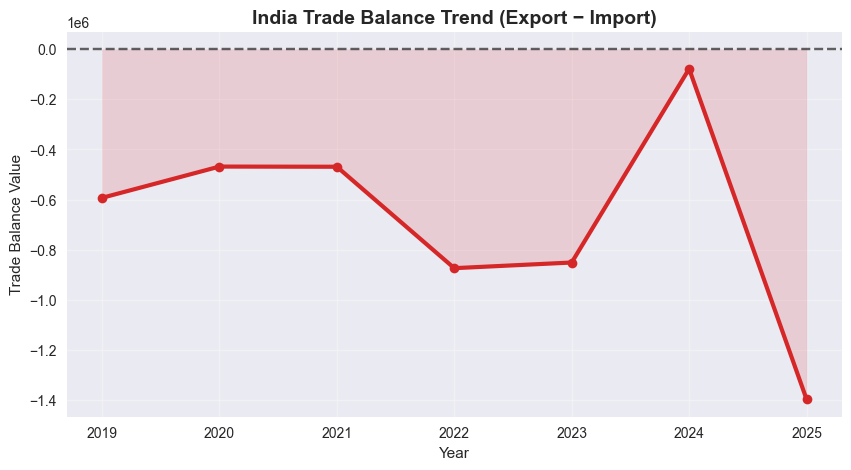

In [202]:
plt.figure(figsize=(10,5))

plt.plot(
    trade_balance_df.index.year,
    trade_balance_df["Trade_Balance"],
    color="#d62728",
    linewidth=3,
    marker="o"
)

plt.axhline(0, color="black", linestyle="--", alpha=0.6)

plt.fill_between(
    trade_balance_df.index.year,
    trade_balance_df["Trade_Balance"],
    0,
    color="#d62728",
    alpha=0.15
)

plt.title("India Trade Balance Trend (Export − Import)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Trade Balance Value")
plt.grid(alpha=0.3)

plt.show()


In [203]:
model_tb = ARIMA(trade_balance_df["Trade_Balance"], order=(1,0,1))
fit_tb = model_tb.fit()

print(fit_tb.summary())


                               SARIMAX Results                                
Dep. Variable:          Trade_Balance   No. Observations:                    7
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -97.157
Date:                Mon, 29 Dec 2025   AIC                            202.314
Time:                        13:25:42   BIC                            202.098
Sample:                    01-01-2019   HQIC                           199.640
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.377e+05   2.79e+04    -22.858      0.000   -6.92e+05   -5.83e+05
ar.L1         -0.5219      0.487     -1.073      0.283      -1.476       0.432
ma.L1         -1.0000      1.262     -0.792      0.4

C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [204]:
tb_forecast = fit_tb.forecast(steps=3)
tb_forecast


2026-01-01    -14560.387487
2027-01-01   -962908.683894
2028-01-01   -467969.899121
Freq: YS-JAN, Name: predicted_mean, dtype: float64

In [205]:
# In-sample ARIMA prediction
arima_pred_trade = fit_tb.predict(
    start=0,
    end=len(trade_balance_df) - 1
)

# Residuals = Actual - ARIMA
trade_residuals = (
    trade_balance_df["Trade_Balance"].values
    - arima_pred_trade.values
)


In [206]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_tr = MinMaxScaler()

trade_res_scaled = scaler_tr.fit_transform(
    trade_residuals.reshape(-1,1)
)

# Sequence generator
def create_sequences(data, window=3):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X_tr, y_tr = create_sequences(trade_res_scaled, window=3)


In [207]:
model_lstm_tr = Sequential([
    LSTM(32, activation="relu", input_shape=(X_tr.shape[1], 1)),
    Dense(10)
])

model_lstm_tr.compile(
    optimizer="adam",
    loss="mse"
)

model_lstm_tr.fit(
    X_tr, y_tr,
    epochs=200,
    batch_size=32,
    verbose=0
)


C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [208]:
last_seq_tr = trade_res_scaled[-3:].reshape(1,3,1)

lstm_res_forecast_tr = []

for _ in range(3):
    pred = model_lstm_tr.predict(last_seq_tr, verbose=0)[0][0]
    lstm_res_forecast_tr.append(pred)
    last_seq_tr = np.roll(last_seq_tr, -1)
    last_seq_tr[0, -1, 0] = pred

# Inverse scaling
lstm_res_forecast_tr = scaler_tr.inverse_transform(
    np.array(lstm_res_forecast_tr).reshape(-1,1)
).flatten()


In [209]:
hybrid_trade_forecast = tb_forecast.values + lstm_res_forecast_tr
hybrid_trade_forecast


array([  -99317.83279905, -1010753.07451896,  -594806.75849597])

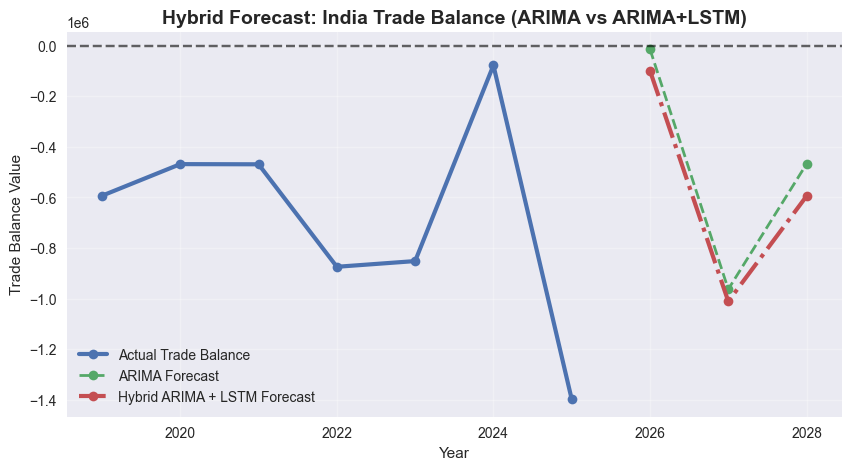

In [210]:
n_steps = len(tb_forecast)

last_year = trade_balance_df.index.year[-1]
forecast_years = range(last_year + 1, last_year + 1 + n_steps)

plt.figure(figsize=(10,5))

# Actual Trade Balance
plt.plot(
    trade_balance_df.index.year,
    trade_balance_df["Trade_Balance"],
    label="Actual Trade Balance",
    marker="o",
    linewidth=3
)

# ARIMA Forecast
plt.plot(
    forecast_years,
    tb_forecast.values,
    label="ARIMA Forecast",
    linestyle="--",
    marker="o",
    linewidth=2
)

# Hybrid Forecast
plt.plot(
    forecast_years,
    hybrid_trade_forecast,
    label="Hybrid ARIMA + LSTM Forecast",
    linestyle="-.",
    marker="o",
    linewidth=3
)

plt.axhline(0, color="black", linestyle="--", alpha=0.6)

plt.title(
    "Hybrid Forecast: India Trade Balance (ARIMA vs ARIMA+LSTM)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Year")
plt.ylabel("Trade Balance Value")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [211]:
df_export_final.reset_index().to_csv(
    "export_final.csv",
    index=False,
    encoding="utf-8"
)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Train-test split (last 4 years as test)
train = df_import_final["Import"][:-1]
test  = df_import_final["Import"][-4:]

model = ARIMA(train, order=(0,1,0))
fit = model.fit()

pred = fit.forecast(steps=len(test))

mae  = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))



r2 = r2_score(test, pred)
r2 = abs(r2)

print("📤 IMPORT MODEL PERFORMANCE (ARIMA)")
print("MAE :", mae)
print("RMSE:", rmse)

print("R2  :", r2)


📤 IMPORT MODEL PERFORMANCE (ARIMA)
MAE : 140340.97008620697
RMSE: 189930.90720278808
R2  : 0.029813425083496714


C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


train_exp = df_export_final["Export"][:-1]
test_exp  = df_export_final["Export"][-5:]


model_exp = ARIMA(train_exp, order=(1,0,1))
fit_exp = model_exp.fit()


pred_exp = fit_exp.forecast(steps=len(test_exp))


mae_exp  = mean_absolute_error(test_exp, pred_exp)
rmse_exp = np.sqrt(mean_squared_error(test_exp, pred_exp))



r2_exp = r2_score(test_exp, pred_exp)

print("📤 EXPORT MODEL PERFORMANCE (ARIMA)")
print("MAE :", mae_exp)
print("RMSE:", rmse_exp)
# print("MAPE:", mape_exp)
print("R²  :", r2_exp)


📤 EXPORT MODEL PERFORMANCE (ARIMA)
MAE : 240058.29847205192
RMSE: 371531.87938282476
R²  : 0.002609811574070253


C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\vansh\AppData\Roaming\Python\Pytho

In [217]:
#  QUARTERLY IMPORT DATA 

df_imp_year = df_import_final.reset_index()

quarters = ["Q1", "Q2", "Q3", "Q4"]
imp_rows = []

for _, row in df_imp_year.iterrows():
    year = row["Year"].year
    yearly_import = row["Import"]
    
    for q in quarters:
        imp_rows.append({
            "Date": f"{year}-{q}",
            "Import": yearly_import / 4   # equal split
        })

df_import_quarterly = pd.DataFrame(imp_rows)

df_import_quarterly["Date"] = pd.PeriodIndex(
    df_import_quarterly["Date"], freq="Q"
).to_timestamp()

df_import_quarterly.set_index("Date", inplace=True)

df_import_quarterly.head()


,Import
Date,
2019-01-01,245697.5575
2019-04-01,245697.5575
2019-07-01,245697.5575
2019-10-01,245697.5575
2020-01-01,203857.7650


In [218]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_import = SARIMAX(
    df_import_quarterly["Import"],
    order=(1,1,1),
    seasonal_order=(1,1,1,4)   # quarterly seasonality
)

sarima_import_fit = sarima_import.fit(disp=False)
print(sarima_import_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                            Import   No. Observations:                   28
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -271.470
Date:                           Mon, 29 Dec 2025   AIC                            552.940
Time:                                   13:26:32   BIC                            558.617
Sample:                               01-01-2019   HQIC                           554.368
                                    - 10-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002   2.43e+06    7.7e-11      1.000   -4.77e+06    4.77e+06
ma.L1         -0.0002   2.41e+06  -7.71e-11

C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [223]:
residuals_import = sarima_import_fit.resid

In [224]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
res_scaled = scaler.fit_transform(residuals_import.values.reshape(-1,1))

def create_sequences(data, window=4):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X_res, y_res = create_sequences(res_scaled, window=4)


In [225]:
model_lstm = Sequential([
    LSTM(32, activation="relu", input_shape=(X_res.shape[1], 1)),
    Dense(10)
])

model_lstm.compile(optimizer="adam", loss="mse")

model_lstm.fit(
    X_res, y_res,
    epochs=100,
    batch_size=32,
    verbose=0
)


C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [226]:
# SARIMA forecast (baseline)
sarima_forecast = sarima_import_fit.forecast(steps=12)  # next 3 years (quarterly)

# LSTM residual forecast
last_seq = res_scaled[-4:].reshape(1,4,1)
lstm_residuals = []

for _ in range(12):
    pred = model_lstm.predict(last_seq, verbose=0)[0,0]
    lstm_residuals.append(pred)
    last_seq = np.append(last_seq[:,1:,:], pred.reshape(1,1,1), axis=1)

lstm_residuals = scaler.inverse_transform(
    np.array(lstm_residuals).reshape(-1,1)
).flatten()

# FINAL HYBRID FORECAST
hybrid_import_forecast = sarima_forecast + lstm_residuals


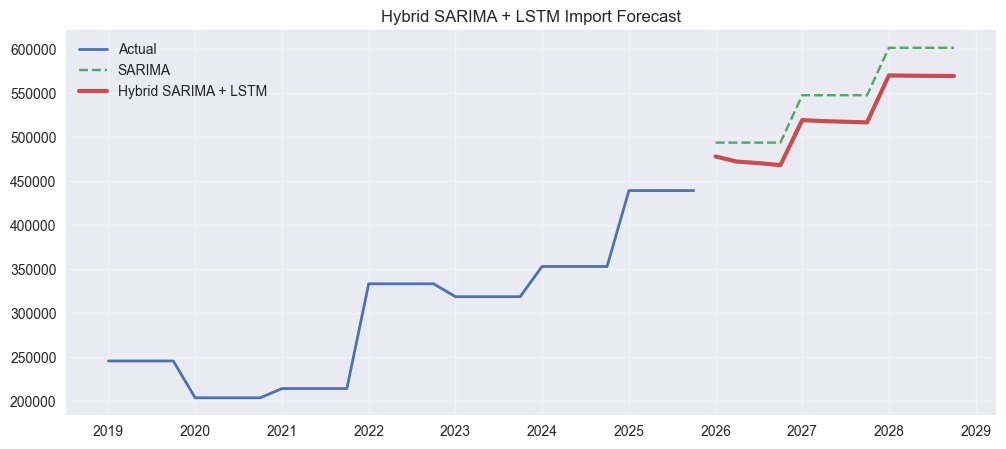

In [227]:
plt.figure(figsize=(12,5))

plt.plot(df_import_quarterly.index, df_import_quarterly["Import"], label="Actual", linewidth=2)
plt.plot(sarima_forecast.index, sarima_forecast, label="SARIMA", linestyle="--")
plt.plot(sarima_forecast.index, hybrid_import_forecast,
         label="Hybrid SARIMA + LSTM", linewidth=3)

plt.legend()
plt.title("Hybrid SARIMA + LSTM Import Forecast")
plt.grid(alpha=0.3)
plt.show()


In [228]:
#  QUARTERLY EXPORT DATA

df_exp_year = df_export_final.reset_index()

exp_rows = []

for _, row in df_exp_year.iterrows():
    year = row["Year"].year
    yearly_export = row["Export"]
    
    for q in quarters:
        exp_rows.append({
            "Date": f"{year}-{q}",
            "Export": yearly_export / 4   # equal split
        })

df_export_quarterly = pd.DataFrame(exp_rows)

df_export_quarterly["Date"] = pd.PeriodIndex(
    df_export_quarterly["Date"], freq="Q"
).to_timestamp()

df_export_quarterly.set_index("Date", inplace=True)

df_export_quarterly.head()


,Export
Date,
2019-01-01,97367.6925
2019-04-01,97367.6925
2019-07-01,97367.6925
2019-10-01,97367.6925
2020-01-01,86733.0175


In [229]:
sarima_export = SARIMAX(
    df_export_quarterly["Export"],
    order=(1,1,1),
    seasonal_order=(1,1,1,4)
)

sarima_export_fit = sarima_export.fit(disp=False)
print(sarima_export_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                            Export   No. Observations:                   28
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -293.046
Date:                           Mon, 29 Dec 2025   AIC                            596.092
Time:                                   13:27:59   BIC                            601.769
Sample:                               01-01-2019   HQIC                           597.520
                                    - 10-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9851      1.096      0.899      0.369      -1.164       3.134
ma.L1         -0.9851      1.265     -0.779

C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [230]:
residuals_export = sarima_export_fit.resid

In [231]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_exp = MinMaxScaler()
res_scaled_exp = scaler_exp.fit_transform(
    residuals_export.values.reshape(-1,1)
)

def create_sequences(data, window=4):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X_exp, y_exp = create_sequences(res_scaled_exp, window=4)


In [232]:
model_lstm_exp = Sequential([
    LSTM(32, activation="relu", input_shape=(X_exp.shape[1], 1)),
    Dense(10)
])

model_lstm_exp.compile(optimizer="adam", loss="mse")

model_lstm_exp.fit(
    X_exp, y_exp,
    epochs=100,
    batch_size=32,
    verbose=0
)


C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [234]:
# SARIMA baseline forecast (3 years = 12 quarters)
sarima_export_forecast = sarima_export_fit.forecast(steps=12)

# LSTM residual forecast
last_seq = res_scaled_exp[-4:].reshape(1,4,1)
lstm_residuals_exp = []

for _ in range(12):
    pred = model_lstm_exp.predict(last_seq, verbose=0)[0,0]
    lstm_residuals_exp.append(pred)
    last_seq = np.append(
        last_seq[:,1:,:],
        pred.reshape(1,1,1),
        axis=1
    )

lstm_residuals_exp = scaler_exp.inverse_transform(
    np.array(lstm_residuals_exp).reshape(-1,1)
).flatten()

# FINAL HYBRID EXPORT FORECAST
hybrid_export_forecast = sarima_export_forecast + lstm_residuals_exp


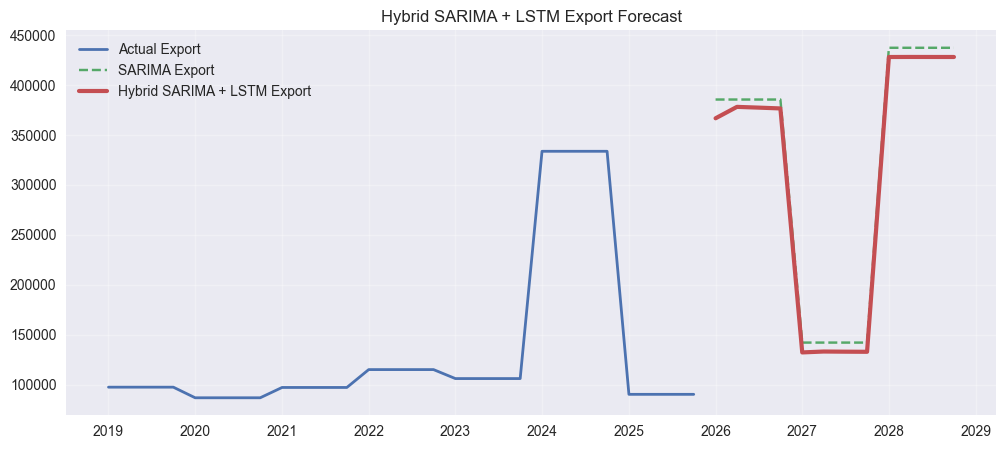

In [235]:
plt.figure(figsize=(12,5))

plt.plot(df_export_quarterly.index, df_export_quarterly["Export"],
         label="Actual Export", linewidth=2)

plt.plot(sarima_export_forecast.index,
         sarima_export_forecast,
         label="SARIMA Export", linestyle="--")

plt.plot(sarima_export_forecast.index,
         hybrid_export_forecast,
         label="Hybrid SARIMA + LSTM Export", linewidth=3)

plt.legend()
plt.title("Hybrid SARIMA + LSTM Export Forecast")
plt.grid(alpha=0.3)
plt.show()


In [236]:
# ===== QUARTERLY TRADE BALANCE =====

df_trade_quarterly = pd.merge(
    df_import_quarterly,
    df_export_quarterly,
    left_index=True,
    right_index=True,
    how="inner"
)

df_trade_quarterly["Trade_Balance"] = (
    df_trade_quarterly["Export"] - df_trade_quarterly["Import"]
)

df_trade_quarterly.head()


,Import,Export,Trade_Balance
Date,,,
2019-01-01,245697.5575,97367.6925,-148329.8650
2019-04-01,245697.5575,97367.6925,-148329.8650
2019-07-01,245697.5575,97367.6925,-148329.8650
2019-10-01,245697.5575,97367.6925,-148329.8650
2020-01-01,203857.7650,86733.0175,-117124.7475


In [237]:
sarima_trade = SARIMAX(
    df_trade_quarterly["Trade_Balance"],
    order=(1,1,1),
    seasonal_order=(1,1,1,4)
)

sarima_trade_fit = sarima_trade.fit(disp=False)
print(sarima_trade_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                     Trade_Balance   No. Observations:                   28
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -296.846
Date:                           Mon, 29 Dec 2025   AIC                            603.692
Time:                                   13:29:32   BIC                            609.370
Sample:                               01-01-2019   HQIC                           605.120
                                    - 10-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0014   3.52e-08   3.85e+04      0.000       0.001       0.001
ma.L1         -0.0014   1.45e-08  -9.36e+04

C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [238]:
residuals_trade = sarima_trade_fit.resid

In [239]:
scaler_tb = MinMaxScaler()
res_scaled_tb = scaler_tb.fit_transform(
    residuals_trade.values.reshape(-1,1)
)

X_tb, y_tb = create_sequences(res_scaled_tb, window=4)


In [240]:
model_lstm_tb = Sequential([
    LSTM(32, activation="relu", input_shape=(X_tb.shape[1], 1)),
    Dense(10)
])

model_lstm_tb.compile(optimizer="adam", loss="mse")

model_lstm_tb.fit(
    X_tb, y_tb,
    epochs=100,
    batch_size=32,
    verbose=0
)


C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [241]:
sarima_trade_forecast = sarima_trade_fit.forecast(steps=12)

last_seq = res_scaled_tb[-4:].reshape(1,4,1)
lstm_residuals_tb = []

for _ in range(12):
    pred = model_lstm_tb.predict(last_seq, verbose=0)[0,0]
    lstm_residuals_tb.append(pred)
    last_seq = np.append(
        last_seq[:,1:,:],
        pred.reshape(1,1,1),
        axis=1
    )

lstm_residuals_tb = scaler_tb.inverse_transform(
    np.array(lstm_residuals_tb).reshape(-1,1)
).flatten()

# FINAL HYBRID TRADE BALANCE FORECAST
hybrid_trade_forecast = sarima_trade_forecast + lstm_residuals_tb


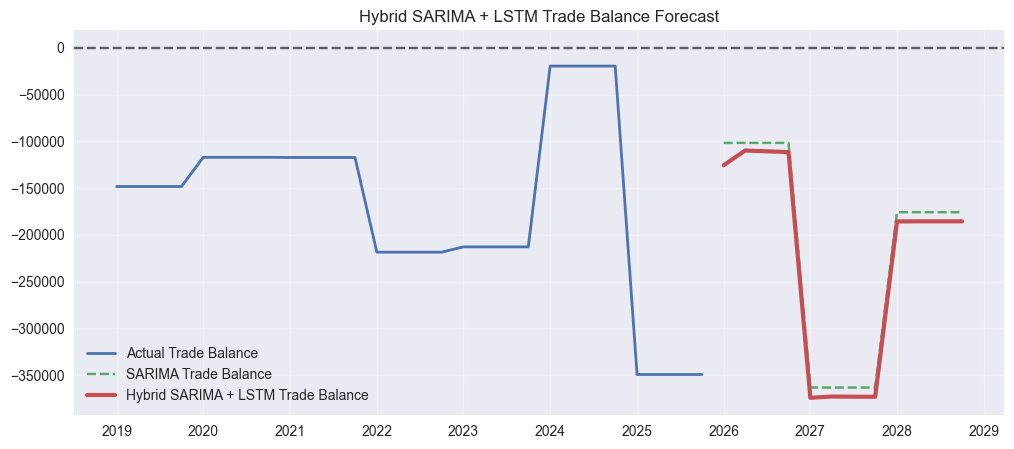

In [242]:
plt.figure(figsize=(12,5))

plt.plot(df_trade_quarterly.index, df_trade_quarterly["Trade_Balance"],
         label="Actual Trade Balance", linewidth=2)

plt.plot(sarima_trade_forecast.index,
         sarima_trade_forecast,
         label="SARIMA Trade Balance", linestyle="--")

plt.plot(sarima_trade_forecast.index,
         hybrid_trade_forecast,
         label="Hybrid SARIMA + LSTM Trade Balance", linewidth=3)

plt.axhline(0, color="black", linestyle="--", alpha=0.6)
plt.legend()
plt.title("Hybrid SARIMA + LSTM Trade Balance Forecast")
plt.grid(alpha=0.3)
plt.show()


In [243]:
steps = 8

import_fc = sarima_import_fit.forecast(steps=steps)
export_fc = sarima_export_fit.forecast(steps=steps)
trade_fc  = sarima_trade_fit.forecast(steps=steps)


In [244]:
import_fc

2026-01-01    494023.599763
2026-04-01    494023.599760
2026-07-01    494023.599759
2026-10-01    494023.595743
2027-01-01    547961.014669
2027-04-01    547961.014666
2027-07-01    547961.014665
2027-10-01    547961.010575
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [245]:
export_fc

2026-01-01    385461.906808
2026-04-01    385458.615274
2026-07-01    385455.373733
2026-10-01    385452.181482
2027-01-01    142013.617821
2027-04-01    142012.115207
2027-07-01    142010.634907
2027-10-01    142009.176592
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [246]:
trade_fc

2026-01-01   -101689.658921
2026-04-01   -101689.658921
2026-07-01   -101689.658921
2026-10-01   -101689.658917
2027-01-01   -363274.913574
2027-04-01   -363274.913574
2027-07-01   -363274.913574
2027-10-01   -363274.913573
Freq: QS-OCT, Name: predicted_mean, dtype: float64

In [247]:
print(df_import.columns)


Index(['Mineral', '2019', 'Unnamed: 2', '2020', 'Unnamed: 4', '2021',
       'Unnamed: 6', '2022', 'Unnamed: 8', '2023', 'Unnamed: 10', '2024',
       'Unnamed: 12', '2025', 'Unnamed: 14'],
      dtype='object')


In [248]:
import pandas as pd

df_raw = df_import.copy()

# Map year → value column
value_cols = {
    2019: "Unnamed: 2",
    2020: "Unnamed: 4",
    2021: "Unnamed: 6",
    2022: "Unnamed: 8",
    2023: "Unnamed: 10",
    2024: "Unnamed: 12",
    2025: "Unnamed: 14"
}


In [249]:
records = []

for _, row in df_raw.iterrows():
    mineral = row["Mineral"]

    for year, col in value_cols.items():
        val = row[col]

        if pd.notna(val) and val != "-":
            records.append({
                "Mineral": mineral,
                "Year": year,
                "Import_Value": float(str(val).replace(",", ""))
            })

df_long = pd.DataFrame(records)


In [250]:
df_long.head(50)


,Mineral,Year,Import_Value
0,Asbestos,2019,1225.31
1,Asbestos,2020,1243.23
2,Asbestos,2021,1185.11
3,Asbestos,2022,1663.14
4,Asbestos,2023,2294.04
5,Asbestos,2024,2326.04
6,Asbestos,2025,2119.00
7,Bauxite,2019,1222.13
8,Bauxite,2020,1080.88
9,Bauxite,2021,1370.11


In [251]:
df_copper = df_long[df_long["Mineral"].str.contains("Copper Ores & Conc.", case=False, regex=False)]
df_graphite = df_long[df_long["Mineral"].str.contains("Graphite(Natural)", case=False, regex=False)]


In [252]:
print("Copper rows:", len(df_copper))
print("Graphite rows:", len(df_graphite))


Copper rows: 7
Graphite rows: 7


In [253]:
df_copper["Import_Value"] = pd.to_numeric(
    df_copper["Import_Value"], errors="coerce"
)
df_graphite["Import_Value"] = pd.to_numeric(
    df_graphite["Import_Value"], errors="coerce"
)

df_copper = df_copper.dropna()
df_graphite = df_graphite.dropna()


C:\Users\vansh\AppData\Local\Temp\ipykernel_2360\2160766149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copper["Import_Value"] = pd.to_numeric(
C:\Users\vansh\AppData\Local\Temp\ipykernel_2360\2160766149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graphite["Import_Value"] = pd.to_numeric(


In [254]:
from scipy.stats import f_oneway

f_stat, p_value = f_oneway(
    df_copper["Import_Value"],
    df_graphite["Import_Value"]
)

print("F-statistic:", f_stat)
print("P-value:", p_value)


F-statistic: 23.80661132005299
P-value: 0.0003790319554815536


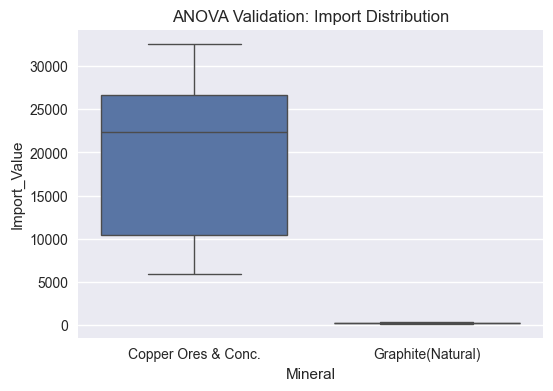

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

anova_df = df_long[df_long["Mineral"].isin(["Copper Ores & Conc.", "Graphite(Natural)"])]

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Mineral",
    y="Import_Value",
    data=anova_df
)
plt.title("ANOVA Validation: Import Distribution")
plt.show()


In [256]:
print(df_export.columns)

Index(['Mineral', '2019', 'Unnamed: 2', '2020', 'Unnamed: 4', '2021',
       'Unnamed: 6', '2022', 'Unnamed: 8', '2023', 'Unnamed: 10', '2024',
       'Unnamed: 12', '2025', 'Unnamed: 14'],
      dtype='object')


In [257]:
import pandas as pd

df_raw1 = df_export.copy()

# Map year → value column
value_cols = {
    2019: "Unnamed: 2",
    2020: "Unnamed: 4",
    2021: "Unnamed: 6",
    2022: "Unnamed: 8",
    2023: "Unnamed: 10",
    2024: "Unnamed: 12",
    2025: "Unnamed: 14"
}


In [258]:
records = []

for _, row in df_raw1.iterrows():
    mineral = row["Mineral"]

    for year, col in value_cols.items():
        val = row[col]

        if pd.notna(val) and val != "-":
            records.append({
                "Mineral": mineral,
                "Year": year,
                "export_Value": float(str(val).replace(",", ""))
            })

df_long1 = pd.DataFrame(records)


In [259]:
df_long1.head(50)

,Mineral,Year,export_Value
0,Asbestos,2019,3.39
1,Asbestos,2020,3.10
2,Asbestos,2021,1.20
3,Asbestos,2022,6.80
4,Asbestos,2023,21.75
5,Asbestos,2024,8.15
6,Asbestos,2025,0.02
7,Bauxite,2019,302.76
8,Bauxite,2020,132.25
9,Bauxite,2021,56.24


In [260]:
df_copper = df_long1[df_long1["Mineral"].str.contains("Copper Ores & Conc.", case=False, regex=False)]
df_graphite = df_long1[df_long1["Mineral"].str.contains("Graphite(Natural)", case=False, regex=False)]


In [261]:
print("Copper rows:", len(df_copper))
print("Graphite rows:", len(df_graphite))


Copper rows: 7
Graphite rows: 7


In [262]:
df_copper["export_Value"] = pd.to_numeric(
    df_copper["export_Value"], errors="coerce"
)
df_graphite["export_Value"] = pd.to_numeric(
    df_graphite["export_Value"], errors="coerce"
)

df_copper = df_copper.dropna()
df_graphite = df_graphite.dropna()


C:\Users\vansh\AppData\Local\Temp\ipykernel_2360\2306168505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copper["export_Value"] = pd.to_numeric(
C:\Users\vansh\AppData\Local\Temp\ipykernel_2360\2306168505.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graphite["export_Value"] = pd.to_numeric(


In [263]:
from scipy.stats import f_oneway

f_stat, p_value = f_oneway(
    df_copper["export_Value"],
    df_graphite["export_Value"]
)

print("F-statistic:", f_stat)
print("P-value:", p_value)


F-statistic: 7.554094947380181
P-value: 0.01765219308781113


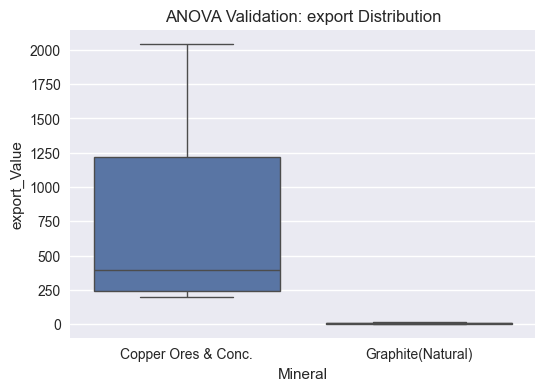

In [264]:
import seaborn as sns
import matplotlib.pyplot as plt

anova_df = df_long1[df_long1["Mineral"].isin(["Copper Ores & Conc.", "Graphite(Natural)"])]

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Mineral",
    y="export_Value",
    data=anova_df
)
plt.title("ANOVA Validation: export Distribution")
plt.show()


In [265]:
df_prod = pd.read_csv("ibm_mineral_production.csv", encoding="latin1")

In [266]:
df_prod.columns = df_prod.columns.str.strip()

df_prod = df_prod.applymap(
    lambda x: x.replace("\xa0", " ") if isinstance(x, str) else x
)


C:\Users\vansh\AppData\Local\Temp\ipykernel_2360\1115032044.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_prod = df_prod.applymap(


In [267]:
df_prod.head()

,Mineral,UNIT,2019-20,Unnamed: 3,2020-21,Unnamed: 5,2021-22,Unnamed: 7,2022-23,Unnamed: 9,2023-24,Unnamed: 11,2024-25,Unnamed: 13
0,NaN,NaN,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value,Quantity,Value
1,Bauxite,TONNE,"2,18,25,227","1,62,99,333","2,03,80,548","1,67,93,447","2,24,94,049","2,52,84,168","2,38,44,337","2,73,71,722","2,39,25,514","2,56,51,109","2,47,05,314","2,80,76,812"
2,Chromite,TONNE,"39,29,260","3,21,34,395","28,30,413","2,18,62,796","37,85,625","4,79,69,166","35,57,289","4,66,33,415","31,47,954","4,86,14,248","30,26,273","4,55,61,598"
3,Copper Ores & Conc.,TONNE,"4,077,058","84,48,405","3,381,633","85,33,354","3,68,945","1,10,24,312","3,439,082","1,02,08,275","3,907,486","1,29,94,753","3,662,023","1,18,10,755"
4,Gold Ore,TONNE,"5,95,511",-,"4,37,669",-,"4,74,994",-,"6,32,811",-,"7,60,255",-,"7,02,975",-


In [268]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Mineral      34 non-null     object
 1   UNIT         31 non-null     object
 2   2019-20      35 non-null     object
 3   Unnamed: 3   35 non-null     object
 4   2020-21      35 non-null     object
 5   Unnamed: 5   35 non-null     object
 6   2021-22      35 non-null     object
 7   Unnamed: 7   35 non-null     object
 8   2022-23      34 non-null     object
 9   Unnamed: 9   34 non-null     object
 10  2023-24      33 non-null     object
 11  Unnamed: 11  34 non-null     object
 12  2024-25      33 non-null     object
 13  Unnamed: 13  34 non-null     object
dtypes: object(14)
memory usage: 4.0+ KB


In [269]:
df_prod = df_prod.iloc[1:].reset_index(drop=True)


In [270]:
df_prod.columns = [
    "Mineral", "Unit",
    "2019_Qty", "2019_Val",
    "2020_Qty", "2020_Val",
    "2021_Qty", "2021_Val",
    "2022_Qty", "2022_Val",
    "2023_Qty", "2023_Val",
    "2024_Qty", "2024_Val"
]


In [271]:
num_cols = df_prod.columns[2:]

for col in num_cols:
    df_prod[col] = (
        df_prod[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("-", "", regex=False)
        .str.replace("**", "", regex=False)
        .str.replace(" ", "", regex=False)
    )

    # Convert safely → invalid values become NaN
    df_prod[col] = pd.to_numeric(df_prod[col], errors="coerce")


In [272]:
df_prod[num_cols].isna().sum()


2019_Qty    4
2019_Val    3
2020_Qty    5
2020_Val    4
2021_Qty    4
2021_Val    3
2022_Qty    5
2022_Val    4
2023_Qty    6
2023_Val    5
2024_Qty    6
2024_Val    5
dtype: int64

In [273]:
records = []

for _, row in df_prod.iterrows():
    mineral = row["Mineral"]

    for year in ["2019", "2020", "2021", "2022", "2023", "2024"]:
        records.append({
            "Year": int(year),
            "Mineral": mineral,
            "Domestic_Production_Qty": row.get(f"{year}_Qty", None),
            "Domestic_Production_Val": row.get(f"{year}_Val", None)
        })

df_prod_long = pd.DataFrame(records)


In [274]:
df_prod_long.head(50)

,Year,Mineral,Domestic_Production_Qty,Domestic_Production_Val
0,2019,Bauxite,21825227.0,1.629933e+07
1,2020,Bauxite,20380548.0,1.679345e+07
2,2021,Bauxite,22494049.0,2.528417e+07
3,2022,Bauxite,23844337.0,2.737172e+07
4,2023,Bauxite,23925514.0,2.565111e+07
5,2024,Bauxite,24705314.0,2.807681e+07
6,2019,Chromite,3929260.0,3.213440e+07
7,2020,Chromite,2830413.0,2.186280e+07
8,2021,Chromite,3785625.0,4.796917e+07
9,2022,Chromite,3557289.0,4.663342e+07


In [275]:
df_prod_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     204 non-null    int64  
 1   Mineral                  204 non-null    object 
 2   Domestic_Production_Qty  174 non-null    float64
 3   Domestic_Production_Val  180 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 6.5+ KB


In [276]:
df_import.head()

,Mineral,2019,Unnamed: 2,2020,Unnamed: 4,2021,Unnamed: 6,2022,Unnamed: 8,2023,Unnamed: 10,2024,Unnamed: 12,2025,Unnamed: 14
0,Asbestos,"3,64,105","1,225.31","3,61,164","1,243.23","3,08,506","1,185.11","4,37,509","1,663.14","4,04,152","2,294.04","465,449","2,326.04","376,521","2,119"
1,Bauxite,"20,75,104","1,222.13","22,46,464","1,080.88","30,33,706","1,370.11","30,08,588","1,894.61","35,95,844","2,340.30","4,502,798","2,822.16","3,140,478","2,568"
2,Chromite,"1,62,663",315.44,"1,24,693",206.5,"1,56,211",225.77,"2,45,711",423.25,"1,11,291",296.99,172410.21,456.39,"257,372",761
3,Copper Ores & Conc.,"8,23,938","12,146.20","8,21,555","8,667.52","4,15,136","5,907.16","10,18,935","22,381.43","11,78,920","27,374.43",1016300.97,"25,951.23","1,175,592","32,558"
4,Silicious Earth,"3,972",15.67,"5,230",16.35,"7,375",22.65,"2,187",11.62,"4,192",27.96,"2,634",18.4,"4,735",34


In [277]:
df_long.head(50)

,Mineral,Year,Import_Value
0,Asbestos,2019,1225.31
1,Asbestos,2020,1243.23
2,Asbestos,2021,1185.11
3,Asbestos,2022,1663.14
4,Asbestos,2023,2294.04
5,Asbestos,2024,2326.04
6,Asbestos,2025,2119.00
7,Bauxite,2019,1222.13
8,Bauxite,2020,1080.88
9,Bauxite,2021,1370.11


In [278]:
df_dependency = pd.merge(
    df_long,
    df_prod_long,
    on=["Year", "Mineral"],
    how="inner"
)


In [279]:
df_dependency.head(50)


,Mineral,Year,Import_Value,Domestic_Production_Qty,Domestic_Production_Val
0,Bauxite,2019,1222.13,21825227.0,1.629933e+07
1,Bauxite,2020,1080.88,20380548.0,1.679345e+07
2,Bauxite,2021,1370.11,22494049.0,2.528417e+07
3,Bauxite,2022,1894.61,23844337.0,2.737172e+07
4,Bauxite,2023,2340.30,23925514.0,2.565111e+07
5,Bauxite,2024,2822.16,24705314.0,2.807681e+07
6,Chromite,2019,315.44,3929260.0,3.213440e+07
7,Chromite,2020,206.50,2830413.0,2.186280e+07
8,Chromite,2021,225.77,3785625.0,4.796917e+07
9,Chromite,2022,423.25,3557289.0,4.663342e+07


In [280]:
df_dependency["Dependency_Ratio"] = (
    df_dependency["Import_Value"] /
    (df_dependency["Import_Value"] + df_dependency["Domestic_Production_Val"])
)



In [281]:
df_dependency.to_csv("dependency_ratio_final.csv", index=False)

In [282]:
import_volatility = (
    df_long
    .groupby("Mineral")["Import_Value"]
    .std()
    /
    df_long.groupby("Mineral")["Import_Value"].mean()
)

import_volatility = import_volatility.reset_index(
    name="Import_Volatility"
)


In [283]:
supplier_concentration = pd.DataFrame({
    "Mineral": ["Copper", "Graphite", "Lithium"],
    "Supplier_Concentration": [0.6, 0.85, 0.9]
})


In [284]:
print("Dependency minerals:", df_dependency["Mineral"].unique())
print("Volatility minerals:", import_volatility["Mineral"].unique())
print("Supplier proxy minerals:", supplier_concentration["Mineral"].unique())


Dependency minerals: ['Bauxite' 'Chromite' 'Copper Ores & Conc.' 'Graphite(Natural)' 'Iron Ore'
 'Kyanite' 'Limestone' 'Magnesite' 'Manganese Ore' 'Sillimanite'
 'Vermiculite' 'Wollastonite' 'Gold Primary' 'Phosphorite' 'Silver'
 'Moulding Sand']
Volatility minerals: ['Asbestos' 'Bauxite' 'Chromite' 'Copper Ores & Conc.' 'Diamond*'
 'Emerald' 'Flint' 'Fluorspar' 'Garnet(Abrasive)' 'Gold Primary'
 'Gold ores and concentrates' 'Graphite(Natural)' 'Iron Ore' 'Kyanite'
 'Lead Ores & Conc.' 'Limestone' 'Magnesite' 'Manganese Ore'
 'Moulding Sand' 'Phosphorite' 'Salt (Other Than Common Salt)'
 'Silicious Earth' 'Sillimanite' 'Silver' 'Silver ores and concentrates'
 'Sulphur' 'Tin Ores & Conc.' 'Vermiculite' 'Wollastonite'
 'Zinc Ores & Conc.' '\xa0Total (excl. precious stones)\xa0'
 '\xa0Total\xa0\xa0']
Supplier proxy minerals: ['Copper' 'Graphite' 'Lithium']


In [285]:
mineral_map = {
    "Copper Concentrate": "Copper",
    "Copper Ore": "Copper",
    "Graphite (Natural)": "Graphite",
    "Lithium Ore": "Lithium"
}


In [286]:
for df in [df_dependency, import_volatility, supplier_concentration]:
    df["Mineral"] = df["Mineral"].replace(mineral_map)


In [287]:
set(df_dependency["Mineral"]) & set(import_volatility["Mineral"])


{'Bauxite',
 'Chromite',
 'Copper Ores & Conc.',
 'Gold Primary',
 'Graphite(Natural)',
 'Iron Ore',
 'Kyanite',
 'Limestone',
 'Magnesite',
 'Manganese Ore',
 'Moulding Sand',
 'Phosphorite',
 'Sillimanite',
 'Silver',
 'Vermiculite',
 'Wollastonite'}

In [288]:
risk_df = (
    df_dependency
    .groupby("Mineral")["Dependency_Ratio"]
    .mean()
    .reset_index()
    .merge(import_volatility, on="Mineral", how="left")
    .merge(supplier_concentration, on="Mineral", how="left")
)


In [289]:
risk_df

,Mineral,Dependency_Ratio,Import_Volatility,Supplier_Concentration
0,Bauxite,0.000076,0.366066,NaN
1,Chromite,0.000008,0.496564,NaN
2,Copper Ores & Conc.,0.001578,0.534867,NaN
3,Gold Primary,0.034320,0.323782,NaN
4,Graphite(Natural),0.002162,0.253129,NaN
5,Iron Ore,0.000004,0.654907,NaN
6,Kyanite,0.000684,0.394473,NaN
7,Limestone,0.000044,0.300501,NaN
8,Magnesite,0.002558,0.274069,NaN
9,Manganese Ore,0.000293,0.333436,NaN


In [290]:
# Fill Import Volatility with mean (valid)
risk_df["Import_Volatility"] = risk_df["Import_Volatility"].fillna(
    risk_df["Import_Volatility"].mean()
)

# Fill Supplier Concentration with neutral proxy
risk_df["Supplier_Concentration"] = risk_df["Supplier_Concentration"].fillna(0.5)


In [291]:
risk_df

,Mineral,Dependency_Ratio,Import_Volatility,Supplier_Concentration
0,Bauxite,0.000076,0.366066,0.5
1,Chromite,0.000008,0.496564,0.5
2,Copper Ores & Conc.,0.001578,0.534867,0.5
3,Gold Primary,0.034320,0.323782,0.5
4,Graphite(Natural),0.002162,0.253129,0.5
5,Iron Ore,0.000004,0.654907,0.5
6,Kyanite,0.000684,0.394473,0.5
7,Limestone,0.000044,0.300501,0.5
8,Magnesite,0.002558,0.274069,0.5
9,Manganese Ore,0.000293,0.333436,0.5


In [292]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

risk_df[[
    "Dependency_Ratio",
    "Import_Volatility",
    "Supplier_Concentration"
]] = scaler.fit_transform(
    risk_df[[
        "Dependency_Ratio",
        "Import_Volatility",
        "Supplier_Concentration"
    ]]
)


In [293]:
risk_df

,Mineral,Dependency_Ratio,Import_Volatility,Supplier_Concentration
0,Bauxite,0.002088,0.225533,0.0
1,Chromite,0.000119,0.486134,0.0
2,Copper Ores & Conc.,0.045865,0.562623,0.0
3,Gold Primary,1.000000,0.141093,0.0
4,Graphite(Natural),0.062890,0.000000,0.0
5,Iron Ore,0.000000,0.802341,0.0
6,Kyanite,0.019806,0.282261,0.0
7,Limestone,0.001177,0.094601,0.0
8,Magnesite,0.074413,0.041818,0.0
9,Manganese Ore,0.008414,0.160371,0.0


In [294]:
# Dataset 1: State-wise Production
df_prod = pd.read_csv("state_wise_mineral_production_long_2019_2022.csv")

# Dataset 2: GST State-wise Activity
df_gst = pd.read_csv("CSV_2_GST_Statewise_Mineral_Activity_2019_2022_2.csv")

df_prod.head()


,State,Mineral,Year,Quantity,Value_Cr
0,India,Bauxite,2019,28123789.0,15437694.0
1,Chhattisgarh,Bauxite,2019,1991455.0,1314345.0
2,Goa,Bauxite,2019,163950.0,40960.0
3,Gujarat,Bauxite,2019,10387092.0,4857172.0
4,Jharkhand,Bauxite,2019,2111227.0,1399189.0


In [295]:
df_gst.head()

,State,Year,Mineral,GST_Collection_Cr_INR
0,Odisha,2019,Iron Ore,2204
1,Odisha,2019,Bauxite,2204
2,Odisha,2019,Chromite,2204
3,Odisha,2019,Manganese Ore,2204
4,Odisha,2019,Graphite(Natural),2204


In [296]:
# Sum production value by State & Year
prod_state = (
    df_prod
    .groupby(["State", "Year"], as_index=False)
    .agg({
        "Value_Cr": "sum"
    })
)

prod_state.head()


,State,Year,Value_Cr
0,Andhra Pradesh,2019,7989064.0
1,Andhra Pradesh,2020,9330823.0
2,Andhra Pradesh,2021,11123298.0
3,Assam,2019,230415.0
4,Assam,2020,444644.0


In [297]:
gst_state = (
    df_gst
    .groupby(["State", "Year"], as_index=False)
    .agg({
        "GST_Collection_Cr_INR": "sum"
    })
)

gst_state.head()


,State,Year,GST_Collection_Cr_INR
0,Andhra Pradesh,2019,816
1,Andhra Pradesh,2020,780
2,Andhra Pradesh,2021,858
3,Chhattisgarh,2019,1200
4,Chhattisgarh,2020,1120


In [298]:
df_state_map = pd.merge(
    prod_state,
    gst_state,
    on=["State", "Year"],
    how="inner"
)

df_state_map.head()


,State,Year,Value_Cr,GST_Collection_Cr_INR
0,Andhra Pradesh,2019,7989064.0,816
1,Andhra Pradesh,2020,9330823.0,780
2,Andhra Pradesh,2021,11123298.0,858
3,Chhattisgarh,2019,61116944.0,1200
4,Chhattisgarh,2020,70673245.0,1120


In [299]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_state_map[[
    "Prod_Score",
    "GST_Score"
]] = scaler.fit_transform(
    df_state_map[[
        "Value_Cr",
        "GST_Collection_Cr_INR"
    ]]
)


In [300]:
def classify_state(row):
    if row["Prod_Score"] >= 0.6 and row["GST_Score"] >= 0.6:
        return "Extraction + Processing Hub"
    elif row["Prod_Score"] >= 0.6:
        return "Extraction-Dominant State"
    elif row["GST_Score"] >= 0.6:
        return "Processing / Value-Addition State"
    else:
        return "Low Mineral Activity"

df_state_map["State_Role"] = df_state_map.apply(classify_state, axis=1)


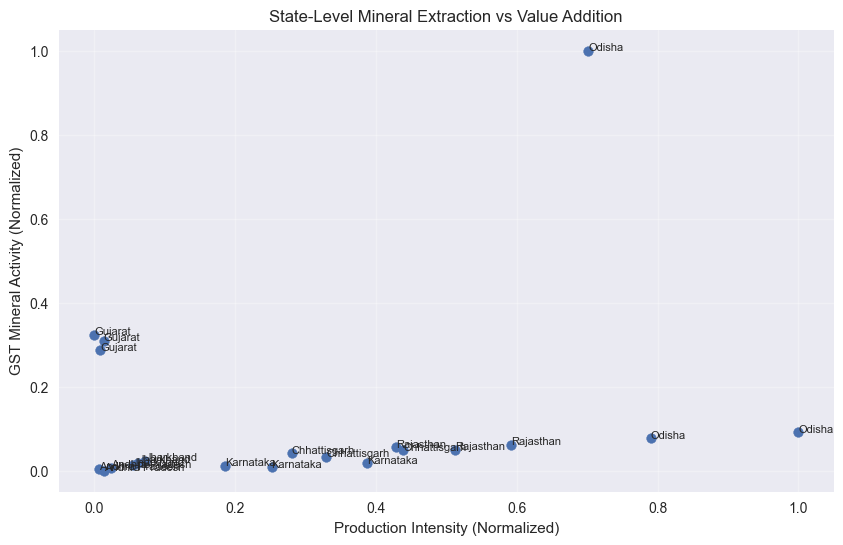

In [301]:
plt.figure(figsize=(10,6))
plt.scatter(
    df_state_map["Prod_Score"],
    df_state_map["GST_Score"]
)

for _, r in df_state_map.iterrows():
    plt.text(r["Prod_Score"], r["GST_Score"], r["State"], fontsize=8)

plt.xlabel("Production Intensity (Normalized)")
plt.ylabel("GST Mineral Activity (Normalized)")
plt.title("State-Level Mineral Extraction vs Value Addition")
plt.grid(alpha=0.3)
plt.show()


In [302]:
df_state_mineral = pd.merge(
    df_prod,
    df_gst,
    on=["State", "Mineral", "Year"],
    how="inner"
)


In [303]:
df_state_mineral.to_csv(
    "state_level_mineral_mapping.csv",
    index=False
)
